In [22]:
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline, classification, evaluation
from pyspark.sql import functions as fn, Row
from pyspark import sql
import re
import pandas as pd

## LOADING DATA AND PREPROCESSING ##

In [180]:
flights_df = spark.read.csv('flights.csv', header = True)
flights_df = flights_df.sample(False, 0.0170)
flights_df.count()

97059

In [181]:
drop_columns = [
'SCHEDULED_DEPARTURE',
'DEPARTURE_TIME', 
'WHEELS_OFF',
'DISTANCE',
'WHEELS_ON',
'SCHEDULED_ARRIVAL',
'ARRIVAL_TIME',
'ARRIVAL_DELAY',
'CANCELLED',
'CANCELLATION_REASON',
'YEAR',
'TAXI_OUT',
'ELAPSED_TIME',
'AIR_TIME','TAXI_IN',
'AIR_SYSTEM_DELAY',
'SECURITY_DELAY',
'AIRLINE_DELAY',
'LATE_AIRCRAFT_DELAY',
'WEATHER_DELAY',
'DIVERTED']

In [182]:
flights_df =  flights_df.drop(*drop_columns)

In [183]:
# Check schema #
flights_df.printSchema()

root
 |-- MONTH: string (nullable = true)
 |-- DAY: string (nullable = true)
 |-- DAY_OF_WEEK: string (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: string (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- DEPARTURE_DELAY: string (nullable = true)
 |-- SCHEDULED_TIME: string (nullable = true)



In [184]:
# Change data types #
flights_df = flights_df.withColumn('DEPARTURE_DELAY_num',fn.col('DEPARTURE_DELAY').cast('int')).drop('DEPARTURE_DELAY')
flights_df = flights_df.withColumn('SCHEDULED_TIME_num',fn.col('SCHEDULED_TIME').cast('int')).drop('SCHEDULED_TIME')

In [185]:
flights_df.show(1)
flights_df.count()

+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+------------------+
|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY_num|SCHEDULED_TIME_num|
+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+------------------+
|    1|  1|          4|     AA|         1112|     N3LAAA|           SFO|                DFW|                -11|               195|
+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+------------------+
only showing top 1 row



97059

In [186]:
# Use bucketizer function to discretize continuous columns #

time_splits = [0.0, 500.0, 1200.0, 1800.0, 2000.0, 2359.0]
delay_splits = [float('-inf'), 0, float('inf')]

time_bucketizer = feature.Bucketizer(splits = time_splits, inputCol = 'SCHEDULED_TIME_num', outputCol = 'SCHEDULED_TIME_idx')
delay_bucketizer = feature.Bucketizer(splits = delay_splits, inputCol = 'DEPARTURE_DELAY_num', outputCol = 'DEPARTURE_DELAY_idx')

In [187]:
bucketizers = [time_bucketizer, delay_bucketizer]
for bucketizer in bucketizers:
    flights_df = bucketizer.transform(flights_df)

In [188]:
flights_df.show(1)
flights_df.count()

+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+------------------+------------------+-------------------+
|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY_num|SCHEDULED_TIME_num|SCHEDULED_TIME_idx|DEPARTURE_DELAY_idx|
+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+------------------+------------------+-------------------+
|    1|  1|          4|     AA|         1112|     N3LAAA|           SFO|                DFW|                -11|               195|               0.0|                0.0|
+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+------------------+------------------+-------------------+
only showing top 1 row



97059

In [189]:
# Convert indices back to appropriate strings #

time_labels = ['Late Night','Morning','Afternoon','Evening','Night']
delay_labels = ['On Time','Delayed']

time_converter = feature.IndexToString(inputCol = "SCHEDULED_TIME_idx", outputCol = "SCHEDULED_TIME_str", labels = time_labels)
delay_converter = feature.IndexToString(inputCol = "DEPARTURE_DELAY_idx", outputCol = "DEPARTURE_DELAY_str", labels = delay_labels)

index_converters = [time_converter, delay_converter]

for converter in index_converters:
    flights_df = converter.transform(flights_df)

In [190]:
# Drop all intermediate columns and rename processed columns back to their original label #

flights_df = flights_df.drop('SCHEDULED_TIME_idx','DEPARTURE_DELAY_idx','DEPARTURE_DELAY_num','SCHEDULED_TIME_num')
flights_df = flights_df.withColumnRenamed('SCHEDULED_TIME_str','SCHEDULED_TIME')\
.withColumnRenamed('DEPARTURE_DELAY_str','DEPARTURE_DELAY')

In [191]:
flights_df.show(1)
flights_df.count()

+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+--------------+---------------+
|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_TIME|DEPARTURE_DELAY|
+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+--------------+---------------+
|    1|  1|          4|     AA|         1112|     N3LAAA|           SFO|                DFW|    Late Night|        On Time|
+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+--------------+---------------+
only showing top 1 row



97059

In [192]:
#  Check for null values in each column and filter results if it returns a value greater than zero#
for col in flights_df.columns:
    print(col, ':', flights_df.filter(flights_df[col].isNull()).count())
    if flights_df.filter(flights_df[col].isNull()).count() > 0:
        print('Filtering...')
        flights_df = flights_df.filter(flights_df[col].isNotNull())

MONTH : 0
DAY : 0
DAY_OF_WEEK : 0
AIRLINE : 0
FLIGHT_NUMBER : 0
TAIL_NUMBER : 292
Filtering...
ORIGIN_AIRPORT : 0
DESTINATION_AIRPORT : 0
SCHEDULED_TIME : 0
DEPARTURE_DELAY : 1172
Filtering...


In [193]:
flights_df.count()

95595

In [196]:
# Filter out all of the airports that are represented as numbers #

expr = "[a-zA-Z]+"
airport_cols = ['ORIGIN_AIRPORT','DESTINATION_AIRPORT']

for col in airport_cols:
    flights_df = flights_df.filter(flights_df[col].rlike(expr))

In [197]:
# Check the final count of records #
flights_df.count()

87607

In [209]:
# Write the clean data to a new .csv for ease of future use #
flights_df.write.csv('flights_clean.csv', header = True)

## MODEL BUILDING AND VALIDATION ##

In [3]:
# Read in the clean data #
flights_df_clean = spark.read.csv('flights_clean.csv', header = True)

In [4]:
flights_df_clean.show(1)

+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+--------------+---------------+
|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_TIME|DEPARTURE_DELAY|
+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+--------------+---------------+
|    6| 17|          3|     OO|         5324|     N951SW|           SBA|                LAX|    Late Night|        On Time|
+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+--------------+---------------+
only showing top 1 row



In [5]:
## THE PIPELINE (indexding, encoding, and assembling) ##

categorical_cols = ['DAY', 'MONTH', 'DAY_OF_WEEK', 'AIRLINE','FLIGHT_NUMBER','TAIL_NUMBER','ORIGIN_AIRPORT',
                    'DESTINATION_AIRPORT','SCHEDULED_TIME']

label_indexer = [feature.StringIndexer(inputCol = "DEPARTURE_DELAY",
                                     outputCol = "DEPARTURE_DELAY_index", handleInvalid = "skip")]

indexers = [feature.StringIndexer(inputCol = column, 
                                  outputCol = "{0}_index".format(column), handleInvalid = "skip")
            for column in categorical_cols
           ]

encoders = [feature.OneHotEncoder(dropLast=False, inputCol = indexer.getOutputCol(),
                                         outputCol = "{0}_encoded".format(indexer.getOutputCol()))
          for indexer in indexers
           ]

assembler = [feature.VectorAssembler(inputCols = [encoder.getOutputCol() for encoder in encoders],
                                     outputCol = "features")
             ]

In [6]:
# Build the preprocessing pipeline, then fit and transform it to the entire dataset #
# Also rename the Departure Delay index to 'label' for ease of future use #

flights_pipe = Pipeline(stages=indexers + label_indexer + encoders +assembler)
flights_model=flights_pipe.fit(flights_df_clean)
flights_transformed = flights_model.transform(flights_df_clean).withColumn('label',fn.col('DEPARTURE_DELAY_index'))\
.drop('DEPARTURE_DELAY_index')

In [7]:
# Make a training, validation, and test split #
training_df, validation_df, testing_df = flights_transformed.randomSplit([0.6, 0.3, 0.1], seed=0)

### Logistic Regression ###

In [99]:
# Build a logistic regression model (default params) using the training data once the preprocessing pipeline has been #
# transformed against it

lr = classification.LogisticRegression(featuresCol='features',labelCol='label',
                                      regParam = 0.01, elasticNetParam = 0.5, maxIter = 10)
lr_model = lr.fit(training_df)

In [9]:
# Transform the model against the validation dataset and print out the accuracy #
lr_predictions = lr_model.transform(validation_df)

evaluator = evaluation.BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(lr_predictions)

In [10]:
# Build an optimization grid in order to test different parameter values #
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

# Find best parameters by cross validating #
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, evaluator=evaluator, numFolds=3)
lr_cvModel = lr_cv.fit(training_df)

In [11]:
# Optimized Parameters #
print('Reg Parameter: ', lr_cvModel.bestModel._java_obj.getRegParam())
print('Elastic Net Parameter: ', lr_cvModel.bestModel._java_obj.getElasticNetParam())
print('Max Iterations: ', lr_cvModel.bestModel._java_obj.getMaxIter())

Reg Parameter:  0.01
Elastic Net Parameter:  0.5
Max Iterations:  10


In [12]:
# Transform the optimized model against the validation dataset and evaluate it #
# This is the validation metric we will use #
lr_opt_predictions = lr_cvModel.bestModel.transform(validation_df)
evaluator = evaluation.BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(lr_opt_predictions)

0.6138867051211684

### Linear SVM ###

In [9]:
# Fit a linear SVM model to the training dataset with default parameters #

flights_svm = classification.LinearSVC(featuresCol='features',labelCol='label')
svm_model = flights_svm.fit(training_df)

In [11]:
# Transform it against the validation dataset and evaluate #
svm_predictions = svm_model.transform(validation_df)
evaluator.evaluate(svm_predictions)

0.5725459509343285

In [ ]:
# Optimize parameters (this takes a while) #
svm_paramGrid = (ParamGridBuilder()
             .addGrid(svm.regParam, [0.0, 0.5, 2.0])
             .addGrid(svm.tol, [0.0, 1e-06, .001])
             .addGrid(svm.maxIter, [50,100,200])
             .build())

svm_cv = CrossValidator(estimator=svm, estimatorParamMaps=svm_paramGrid, evaluator=evaluator, numFolds=3)
svm_cvModel = svm_cv.fit(training_df)

In [ ]:
# Optimized Parameters #
print('Regularization Parameter: ', svm_cvModel.bestModel._java_obj.getRegParam())
print('Tolerance: ', svm_cvModel.bestModel._java_obj.getTol())
print('Max Iterations: ',svm_cvModel.bestModel._java_obj.getMaxIter())

In [ ]:
svm_opt_predictions = svm_cvModel.bestModel.transform(validation_df)
evaluator = evaluation.BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(svm_opt_predictions)

### Random Forest ###

In [8]:
# Fit a random forest classifier to the training dataset with default parameters #

rf = classification.RandomForestClassifier(featuresCol = "features", labelCol = "label",
                                          maxDepth = 10, maxBins = 60, numTrees = 50)
rf_model = rf.fit(training_df)

In [19]:
# Evaluate initial model #

rf_predictions = rf_model.transform(validation_df)
evaluator = evaluation.BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(rf_predictions)

0.6087871158607203

In [9]:
# Optimize parameters (this takes a while)#
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10])
             .addGrid(rf.maxBins, [20,60])
             .addGrid(rf.numTrees, [20, 50])
             .build())

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, evaluator=evaluator, numFolds=3)
rf_cvModel = rf_cv.fit(training_df)

In [17]:
# Optimized Parameters #
print('Max Depth: ', rf_cvModel.bestModel._java_obj.getMaxDepth())
print('Max Bins: ', rf_cvModel.bestModel._java_obj.getMaxBins())
print('Number of Trees: ',rf_cvModel.bestModel._java_obj.getNumTrees())

NameError: name 'rf_cvModel' is not defined

In [13]:
rf_opt_predictions = rf_cvModel.bestModel.transform(validation_df)
evaluator = evaluation.BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(rf_opt_predictions)

0.6061652404503824

### Naive Bayes ###

In [14]:
# Fit a naive bayes model to the training data with default parameters #

nb = classification.NaiveBayes()
nb_model = nb.fit(training_df)

In [15]:
# Transform it against the validation data #

nb_predictions = nb_model.transform(validation_df)
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='label')
evaluator.evaluate(nb_predictions)

0.5891500102017156

In [18]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
nb_paramGrid = (ParamGridBuilder()
             .addGrid(nb.smoothing, [0.05,1,2])
             .build())

nb_cv = CrossValidator(estimator=nb, estimatorParamMaps=nb_paramGrid, evaluator=evaluator, numFolds=3)
nb_cvModel = nb_cv.fit(training_df)

In [20]:
# Optimized Parameters #
print('Smoothing: ', nb_cvModel.bestModel._java_obj.getSmoothing())

Smoothing:  2.0


In [21]:
nb_opt_predictions = nb_cvModel.bestModel.transform(validation_df)
evaluator.evaluate(nb_opt_predictions)

0.5900593818688199

### Validation Summary ###

#### Logistic Regression ####
- Optimized AUC: **0.613**

#### Linear SVM ####
- Optimized AUC: **0.605**

#### Random Forest ####
- Optimized AUC: **0.606**

#### Naive Bayes ####
- Optimized AUC: **0.590**

*Based on these validation metrics, Logistic Regression is the model that we will use on the testing data.* 

## Testing ##

In [15]:
test_predictions = lr_cvModel.bestModel.transform(testing_df)
print('Testing AUC: ', evaluator.evaluate(test_predictions))

Testing AUC:  0.6147212269441672


## Logistic Regression Coefficients ##

In [101]:
# Extract the feature indices and names from the metadata of the encoded features, and then map the model's feature
# coefficients back onto them.

from itertools import chain
import matplotlib.pyplot as plt

attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*training_df
        .schema["features"]
        .metadata["ml_attr"]["attrs"].values())))

mapped_coefficients = [(name, lr_model.coefficients[idx])
                      for idx, name in attrs]

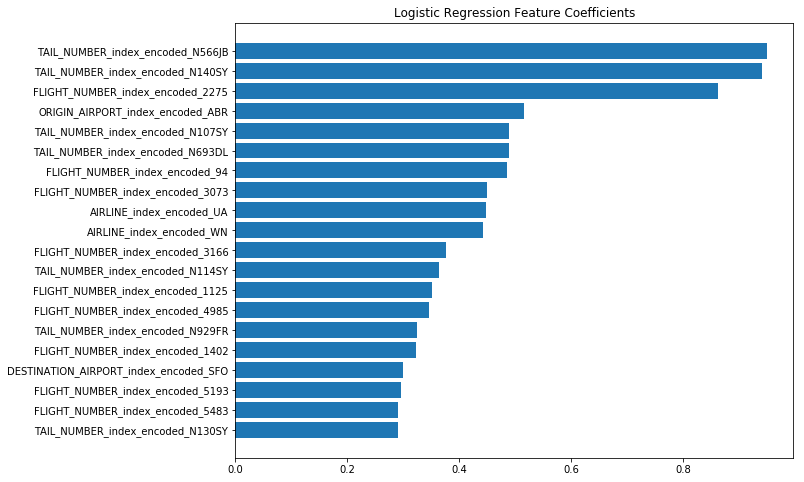

<Figure size 432x288 with 0 Axes>

In [102]:
# Get the top 20 coefficients, and then plot them #

top_coefficients = sorted(mapped_coefficients, key = lambda x: x[1], reverse=True)[:20]
names = list(zip(*top_coefficients))[0]
imp = list(zip(*top_coefficients))[1]
x_pos = np.arange(len(names))
plt.figure(figsize = (10,8))
plt.barh(x_pos[::-1], imp, align = 'center')
plt.yticks(x_pos[::-1], names, linespacing = 2)
plt.title('Logistic Regression Feature Coefficients')
plt.show()

plt.savefig('lr_coefficients.pdf', bbox_inches="tight")

## Random Forest Feature Importances ##

In [52]:
# Similar to the LR model, map the random forest model's feature importances back onto the features
# themselves (the mapping can take a while)#

mapped_importances = [(name, rf_model.featureImportances[idx])
 for idx, name in attrs]

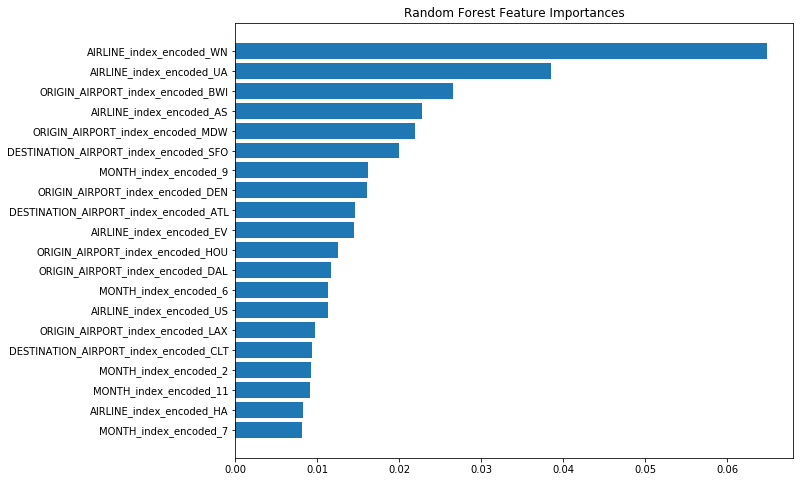

<Figure size 432x288 with 0 Axes>

In [98]:
# Get the top 20 importances, and then plot them #

top_importances = sorted(mapped_importances, key = lambda x: x[1], reverse=True)[:20]
names = list(zip(*top_importances))[0]
imp = list(zip(*top_importances))[1]
x_pos = np.arange(len(names))
plt.figure(figsize = (10,8))
plt.barh(x_pos[::-1], imp, align = 'center')
plt.yticks(x_pos[::-1], names, linespacing = 2)
plt.title('Random Forest Feature Importances')
plt.show()

plt.savefig('feature_importances.pdf', bbox_inches="tight")